In [1]:
print("Importing misc libraries")
import sys
import os
import torch
#import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import datetime

print("Updating sys.path")
project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
models_path = Path.cwd().parent
if str(models_path) not in sys.path:
    sys.path.append(str(models_path))
    
print("Importing torch libraries")
from torch.utils.data import DataLoader
import multiprocessing
from torchvision.transforms import ToTensor
import torch
from torch.optim import Adam, AdamW
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau, ExponentialLR, ChainedScheduler
from torch.amp import autocast, GradScaler
import torch.nn.functional as F
    
print("Importing swin lib")
import importlib
import swin.Swin as s
importlib.reload(s)

print("Importing dataset+loss lib")
import dataset.IntersectionDataset
importlib.reload(dataset.IntersectionDataset)
from dataset.IntersectionDataset import IntersectionDataset, IntersectionDataset2, IntersectionDatasetClasses, custom_collate_fn
import loss.loss_lib as ll
importlib.reload(ll)

dataset_dir = "../../dataset/dataset/train"
img_transform = ToTensor()
path_transform = ToTensor()
dataset_train = IntersectionDatasetClasses(root_dir=dataset_dir, 
                                    transform=img_transform,
                                    path_transform=path_transform)

dataset_dir = "../../dataset/dataset/test"
img_transform = ToTensor()
path_transform = ToTensor()
dataset_test = IntersectionDatasetClasses(root_dir=dataset_dir,
                                   transform=img_transform,
                                   path_transform=path_transform)
print(len(dataset_train))
print(len(dataset_test))

num_workers = multiprocessing.cpu_count()
b = 8

train_dataloader = DataLoader(dataset_train, batch_size=b, shuffle=True, num_workers=num_workers, pin_memory=True, persistent_workers=True, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(dataset_test, batch_size=b, shuffle=True, num_workers=num_workers, pin_memory=True, persistent_workers=True, collate_fn=custom_collate_fn)

Importing misc libraries
Updating sys.path
Importing torch libraries
Importing swin lib
Importing dataset+loss lib
904
32


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try: 
    del(model)
except NameError:
    pass
model = s.Swin().to(device) # background, left, right, ahead, stacked


try:
    del(optimizer)
except NameError:
    pass
#optimizer = Adam(model.parameters(), lr=1e-5)
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

try:
    del(scheduler)
except NameError:
    pass
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-5)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, min_lr=1e-6)
#scheduler2 = ExponentialLR(optimizer, gamma=0.95)
#scheduler = ChainedScheduler([scheduler1, scheduler2])

try:
    del(scaler)
except NameError:
    pass
scaler = GradScaler(device=device)

class_counts = torch.tensor([152000, 2000, 2000, 2000, 2000], dtype=torch.float)
weights = 1.0 / class_counts
#weights = weights / weights.sum()
weights = torch.log1p(class_counts.sum() / class_counts)
lce = torch.nn.CrossEntropyLoss(weight=weights.to(device))
lce = lce.to(device)
#lfl = ll.FocalLoss(alpha=weights.to(device), gamma=2.0).to(device)
#lcm = ll.CmapLoss().to(device)
#lbc = ll.BCELoss().to(device)

In [3]:
from tqdm.notebook import tqdm

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

n_epochs = 1
alpha = 0.5
epochs = tqdm(range(n_epochs), desc="Training", unit=" epoch")

save_epochs = [10, 50, 100, 500]

#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

for epoch in epochs:
    model.train()
    running_train_loss = 0.0
    running_train_correct = 0
    running_train_total = 0
    
    batches = tqdm(train_dataloader, desc="Batches", unit=" batch", leave=False)
    
    for batch in batches:
        satellite = batch["satellite"].to(device, non_blocking=True)
        class_labels = batch["class_labels"].to(device, non_blocking=True)
        #cold_maps = batch["paths"]
        #paths_c = [torch.as_tensor(p["cold_map"]).to(device) for p in cold_maps[0]]
        
        class_labels = class_labels.squeeze(1)
        
        optimizer.zero_grad()
        
        with autocast("cuda"):
            output = model(satellite)
            L_ce = lce(output, class_labels)
            #L_fl = lfl(output, class_labels)
            loss = L_ce
            
        scaled_loss = scaler.scale(loss)
        scaled_loss.backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_train_loss += loss.item()
        
        p = torch.argmax(output, dim=1)
        running_train_correct += (p == class_labels).sum().item()
        running_train_total += class_labels.size(0)
        
        batches.set_postfix({"Loss": loss.item()})
        
        
    avg_train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    train_accuracy = running_train_correct / running_train_total
    train_accuracies.append(train_accuracy)
    
    model.eval()
    running_test_loss = 0.0
    running_test_correct = 0
    running_test_total = 0
    
    test_batches = tqdm(test_dataloader, desc="Batches", unit=" batch", leave=False)
    with torch.no_grad():
        for batch in test_batches:
            satellite = batch["satellite"].to(device, non_blocking=True)
            class_labels = batch["class_labels"].to(device, non_blocking=True)
            
            class_labels = class_labels.squeeze(1)
            
            with autocast("cuda"):
                output = model(satellite)
                L_ce = lce(output, class_labels)
                #L_fl = lfl(output, class_labels)
                loss = L_ce
            
            running_test_loss += loss.item()
            
            p = torch.argmax(output, dim=1)
            running_test_correct += (p == class_labels).sum().item()
            running_test_total += class_labels.size(0)
            
            test_batches.set_postfix({"Loss": loss.item()})
            
    test_batches.close()
            
    avg_test_loss = running_test_loss / len(test_dataloader)
    test_losses.append(avg_test_loss)
    
    test_accuracy = running_test_correct / running_test_total
    test_accuracies.append(test_accuracy)
    
    scheduler.step()  
    
    if (epoch + 1) in save_epochs:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_losses,
            'test_losses': test_losses,
            'train_accuracies': train_accuracies,
            'test_accuracies': test_accuracies,
        }
        #os.makedirs('./ckpt', exist_ok=True)
        
        # f"c_{model}_{M}_{D}_{epoch}_{loss_fn}_{optimizer}_{scheduler}_{[opt]}"
        date = datetime.datetime.now().strftime("%m_%d")
        torch.save(checkpoint, f'./ckpt/c_swin_{date}_{epoch + 1}_ce_adamw_cos.pth')
        
    epochs.set_postfix({"Train Loss": avg_train_loss, "Test Loss": avg_test_loss, "Train Accuracy": train_accuracy, "Test Accuracy": test_accuracy})
    batches.close()
    
epochs.close()

    
#torch.save(model.state_dict(), "model_200e_ce_new_dataset_3class.pth")

Training:   0%|          | 0/1 [00:00<?, ? epoch/s]

Batches:   0%|          | 0/113 [00:00<?, ? batch/s]

Batches:   0%|          | 0/4 [00:00<?, ? batch/s]

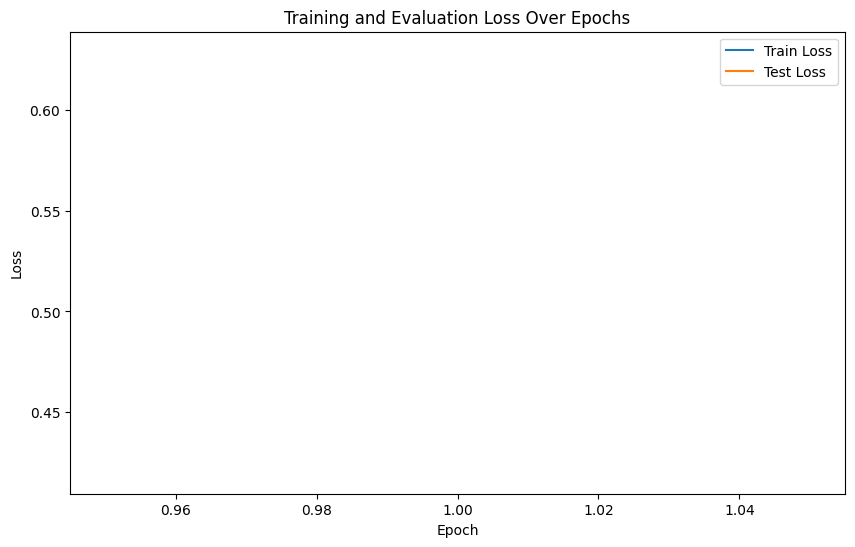

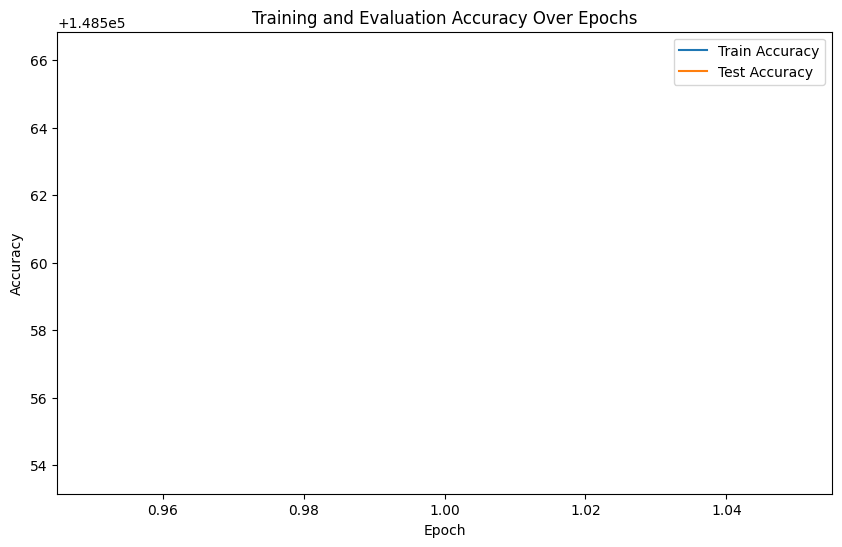

In [4]:
n_epochs = len(train_losses)
train_losses = train_losses
test_losses = test_losses
train_accuracies = train_accuracies
test_accuracies = test_accuracies
# Plotting the loss graphs
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, n_epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss Over Epochs")
plt.legend()
plt.show()

# Plotting the accuracy graphs
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, n_epochs + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Evaluation Accuracy Over Epochs")
plt.legend()
plt.show()